<img src="images/logoUB.svg"  style="max-width:20%">

# Final project Machine Learning 2019-2020
#### Master in Innovation and Entrepreneurship in Biomedical Engineering
##### Authors: Arantxa Palma Rotaeche, Mónica Tuta

<center>
<h4>
    Heart disease binary classification from clinical data
    </h4> 
<img src="images/heartDesease.jpg"  style="max-width:30%">
</center>

<center>
General workflow<br>
This notebook includes three comparative analysis (Attempts) <br>
<img src="images/FlowDiagram.png"  style="max-width:40%">
</center>

## Contents

1. [Problem description](#pd)
1. [Upload data](#ud)
1. [Data description](#dd)
1. [Data exploration and preprocessing](#de)
    1. Dimensionality reduction
        1. Feature selection
        1. PCA
        1. LDA
1. [Modeling](#mo)
    1. KNN

### Problem Description <a class="anchor" id="pd"></a>

According to the World Health Organization, cardiovascular diseases (CVDs) are the **number 1** cause of death globally, around **17.9 million** people die each year, **31%** of the deaths worldwide. More than **75%** of the cases occur in low and middle income countries and **85%** are due to heart attacks and strokes. CVDs are a group of disorders of the heart and blood vessels and include coronary heart disease, cerebrovascular disease, rheumatic heart disease and other conditions.<br>

Individuals at risk of CVD may demonstrate raised blood pressure, glucose, and lipids as well as overweight and obesity. Millions of people worldwide struggle to control the risk factors that lead to cardiovascular disease, many others remain unaware that they are at high risk. Many heart attacks and strokes can be prevented by controlling major risk factors through lifestyle interventions and drug treatment where necessary.<br>

The risk factors for CVD include behavioral factors, such as tobacco use, an unhealthy diet, harmful use of alcohol and inadequate physical activity, and physiological factors, including high blood pressure (hypertension), high blood cholesterol and high blood sugar or glucose which are linked to underlying social determinants and drivers, such as ageing, income and urbanization.<br>

*Identifying those at highest risk of CVDs and ensuring they receive appropriate treatment can prevent premature deaths. One way is to perform analyses (quantitative) to predict or classify whether the population are prone to CVDs according to significantly health features and act on them in advance*

#### Packages

In [1]:
#Load libraries
suppressMessages(library(ggpubr))
suppressMessages(library(tidyverse))
suppressMessages(library(Hmisc))
suppressMessages(library(corrplot))
suppressMessages(library(purrr))
suppressMessages(library(tidyr))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(gridExtra))
#Library for dummy variables
suppressMessages(library(dummies))
#Libraries for feature selection
suppressMessages(library("Boruta"))
suppressMessages(library("mlbench"))
suppressMessages(library("caret"))
#Library for LDA
suppressMessages(library("MASS"))

### Upload Data <a class="anchor" id="ud"></a>

In [2]:
## Upload dataset
heartOriginal <- read.csv(file = 'heart.csv')
cat('Dimension of the dataset:', dim(heartOriginal)[1],"x",dim(heartOriginal)[2])
head(heartOriginal)

Dimension of the dataset: 303 x 14

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>
1,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
2,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
3,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
4,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
5,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
6,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1


### Data description <a class="anchor" id="dd"></a>

#### Contents

- age - age in years
- **sex** - (1 = male; 0 = female)
- **cp** - chest pain type (0 = typical angina, 1 = atypical angina, 2 = non-anginal pain, 3 = asymptomatic)
- trestbps - resting blood pressure (in mm Hg on admission to the hospital)
- chol - serum cholestoral in mg/dl
- **fbs** - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- restecg - resting electrocardiographic results (0= normal, 1= having ST-T wave abnormality (T wave inversions and/or ST 
                    elevation or depression of > 0.05 mV), 2= showing probable or definite left ventricular hypertrophy)
- thalach - maximum heart rate achieved
- **exang** - exercise induced angina (1 = yes; 0 = no)
- oldpeak - ST depression induced by exercise relative to rest
- **slope** - the slope of the peak exercise ST segment (0 = upsloping, 1 = flat, 2 = downsloping)
- ca - number of major vessels (0-3) colored by flourosopy
- **thal** - (3 = normal; 6 = fixed defect; 7 = reversable defect)
- **target** - have disease or not (1=yes, 0=no)


**Bold** features are categorical

***Creators***:
1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
1. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

Donor: David W. Aha (aha '@' ics.uci.edu) (714) 856-8779

#### Summary

In [3]:
summary(heartOriginal)

      age             sex               cp           trestbps    
 Min.   :29.00   Min.   :0.0000   Min.   :0.000   Min.   : 94.0  
 1st Qu.:47.50   1st Qu.:0.0000   1st Qu.:0.000   1st Qu.:120.0  
 Median :55.00   Median :1.0000   Median :1.000   Median :130.0  
 Mean   :54.37   Mean   :0.6832   Mean   :0.967   Mean   :131.6  
 3rd Qu.:61.00   3rd Qu.:1.0000   3rd Qu.:2.000   3rd Qu.:140.0  
 Max.   :77.00   Max.   :1.0000   Max.   :3.000   Max.   :200.0  
      chol            fbs            restecg          thalach     
 Min.   :126.0   Min.   :0.0000   Min.   :0.0000   Min.   : 71.0  
 1st Qu.:211.0   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:133.5  
 Median :240.0   Median :0.0000   Median :1.0000   Median :153.0  
 Mean   :246.3   Mean   :0.1485   Mean   :0.5281   Mean   :149.6  
 3rd Qu.:274.5   3rd Qu.:0.0000   3rd Qu.:1.0000   3rd Qu.:166.0  
 Max.   :564.0   Max.   :1.0000   Max.   :2.0000   Max.   :202.0  
     exang           oldpeak         slope             ca        
 Mi

### Data exploration and preprocessing <a class="anchor" id="de"></a>

#### Identify and treat "NA" values

In [4]:
#### Checking if there are values codified as NA
cat("Number of NA in the dataset:",sum(is.na(heartOriginal)))

#### Eliminating missing variables in "Thal".
#The categories labeled with 0 are considered as NaN values here as well because in the description of the dataset they are not considered as a real category but as missing values
heartOriginal$thal[heartOriginal$thal == "0"] <- NA
heartOriginal%>% count(thal)
heart<- na.omit(heartOriginal)
heart%>% count(thal)
cat("New dimension of the dataset: ", dim(heart)[1], "x", dim(heart)[2])

#Data for PCA
heartForLatterUse<-heart

Number of NA in the dataset: 0

thal,n
<int>,<int>
1,18
2,166
3,117
NA,2


thal,n
<int>,<int>
1,18
2,166
3,117


New dimension of the dataset:  301 x 14

#### Feature selection

Feature selection is a crucial step in predictive modeling. This technique achieves supreme importance when a data set comprised of several variables is given for model building. Generally, whenever you want to reduce the dimensionality of the data you come across methods like Principal Component Analysis, Singular Value decomposition etc. So it's natural to ask why you need other feature selection methods at all. The thing with these techniques is that they are unsupervised ways of feature selection: take, for example, PCA, which uses variance in data to find the components. These techniques don't take into account the information between feature values and the target class or values. Also, there are certain assumptions, such as normality, associated with such methods which require some kind of transformations before starting to apply them. These constraints doesn't apply to all kinds of data.

**Boruta** is a feature selection algorithm. Precisely, it works as a wrapper algorithm around Random Forest. This package derive its name from a demon in Slavic mythology who dwelled in pine forests.
You can improve your model by feeding in only those features that are uncorrelated and non-redundant. This is where feature selection plays an important role. Not only it helps in training your model faster but also reduces the complexity of the model, makes it easier to interpret and improves the accuracy, precision or recall, whatever may the performance metric be.
in wrapper methods, you try to use a subset of features and train a model using them. Based on the inferences that you draw from the previous model, you decide to add or remove features from the subset. Forward Selection, Backward elimination are some of the examples for wrapper methods.
the wrapper methods which is readily available in R through a package called `Boruta`

In [5]:
# Boruta algorithm
set.seed(111)
boruta<- Boruta(target~.,data=heart,doTrace=2,maxRuns=500)
print(boruta)

 1. run of importance source...


 2. run of importance source...


 3. run of importance source...


 4. run of importance source...


 5. run of importance source...


 6. run of importance source...


 7. run of importance source...


 8. run of importance source...


 9. run of importance source...


 10. run of importance source...


 11. run of importance source...


After 11 iterations, +3.8 secs: 


 confirmed 9 attributes: age, ca, cp, exang, oldpeak and 4 more;


 rejected 1 attribute: chol;


 still have 3 attributes left.



 12. run of importance source...


 13. run of importance source...


 14. run of importance source...


 15. run of importance source...


After 15 iterations, +5 secs: 


 rejected 1 attribute: fbs;


 still have 2 attributes left.



 16. run of importance source...


 17. run of importance source...


 18. run of importance source...


 19. run of importance source...


 20. run of importance source...


 21. run of importance source...


 22. run of importance source...


 23. run of importance source...


 24. run of importance source...


 25. run of importance source...


 26. run of importance source...


 27. run of importance source...


 28. run of importance source...


 29. run of importance source...


 30. run of importance source...


 31. run of importance source...


 32. run of importance source...


 33. run of importance source...


 34. run of importance source...


 35. run of importance source...


 36. run of importance source...


 37. run of importance source...


 38. run of importance source...


 39. run of importance source...


 40. run of importance source...


 41. run of importance source...


 42. run of importance source...


 43. run of importance source...


 44. run of importance source...


 45. run of importance source...


 46. run of importance source...


 47. run of importance source...


 48. run of importance source...


 49. run of importance source...


After 49 iterations, +16 secs: 


 rejected 1 attribute: restecg;


 still have 1 attribute left.



 50. run of importance source...


 51. run of importance source...


 52. run of importance source...


 53. run of importance source...


 54. run of importance source...


 55. run of importance source...


 56. run of importance source...


 57. run of importance source...


 58. run of importance source...


 59. run of importance source...


 60. run of importance source...


 61. run of importance source...


 62. run of importance source...


 63. run of importance source...


 64. run of importance source...


 65. run of importance source...


 66. run of importance source...


 67. run of importance source...


 68. run of importance source...


 69. run of importance source...


 70. run of importance source...


 71. run of importance source...


 72. run of importance source...


 73. run of importance source...


 74. run of importance source...


 75. run of importance source...


 76. run of importance source...


 77. run of importance source...


 78. run of importance source...


 79. run of importance source...


 80. run of importance source...


 81. run of importance source...


 82. run of importance source...


 83. run of importance source...


 84. run of importance source...


 85. run of importance source...


 86. run of importance source...


 87. run of importance source...


 88. run of importance source...


 89. run of importance source...


 90. run of importance source...


 91. run of importance source...


 92. run of importance source...


 93. run of importance source...


 94. run of importance source...


 95. run of importance source...


 96. run of importance source...


 97. run of importance source...


 98. run of importance source...


 99. run of importance source...


 100. run of importance source...


 101. run of importance source...


 102. run of importance source...


 103. run of importance source...


 104. run of importance source...


 105. run of importance source...


 106. run of importance source...


 107. run of importance source...


 108. run of importance source...


 109. run of importance source...


 110. run of importance source...


 111. run of importance source...


 112. run of importance source...


 113. run of importance source...


 114. run of importance source...


 115. run of importance source...


 116. run of importance source...


 117. run of importance source...


 118. run of importance source...


 119. run of importance source...


 120. run of importance source...


 121. run of importance source...


 122. run of importance source...


 123. run of importance source...


 124. run of importance source...


 125. run of importance source...


 126. run of importance source...


 127. run of importance source...


 128. run of importance source...


 129. run of importance source...


 130. run of importance source...


 131. run of importance source...


 132. run of importance source...


 133. run of importance source...


 134. run of importance source...


 135. run of importance source...


 136. run of importance source...


 137. run of importance source...


 138. run of importance source...


 139. run of importance source...


 140. run of importance source...


 141. run of importance source...


 142. run of importance source...


 143. run of importance source...


 144. run of importance source...


 145. run of importance source...


 146. run of importance source...


 147. run of importance source...


 148. run of importance source...


 149. run of importance source...


 150. run of importance source...


 151. run of importance source...


 152. run of importance source...


 153. run of importance source...


 154. run of importance source...


 155. run of importance source...


 156. run of importance source...


 157. run of importance source...


 158. run of importance source...


 159. run of importance source...


 160. run of importance source...


 161. run of importance source...


 162. run of importance source...


 163. run of importance source...


 164. run of importance source...


 165. run of importance source...


 166. run of importance source...


 167. run of importance source...


 168. run of importance source...


 169. run of importance source...


 170. run of importance source...


 171. run of importance source...


 172. run of importance source...


 173. run of importance source...


 174. run of importance source...


 175. run of importance source...


 176. run of importance source...


 177. run of importance source...


 178. run of importance source...


 179. run of importance source...


 180. run of importance source...


 181. run of importance source...


 182. run of importance source...


 183. run of importance source...


 184. run of importance source...


 185. run of importance source...


 186. run of importance source...


 187. run of importance source...


 188. run of importance source...


 189. run of importance source...


 190. run of importance source...


 191. run of importance source...


 192. run of importance source...


 193. run of importance source...


 194. run of importance source...


 195. run of importance source...


 196. run of importance source...


 197. run of importance source...


 198. run of importance source...


 199. run of importance source...


 200. run of importance source...


 201. run of importance source...


 202. run of importance source...


 203. run of importance source...


 204. run of importance source...


 205. run of importance source...


 206. run of importance source...


 207. run of importance source...


 208. run of importance source...


 209. run of importance source...


 210. run of importance source...


 211. run of importance source...


 212. run of importance source...


 213. run of importance source...


 214. run of importance source...


 215. run of importance source...


 216. run of importance source...


 217. run of importance source...


 218. run of importance source...


 219. run of importance source...


 220. run of importance source...


 221. run of importance source...


 222. run of importance source...


 223. run of importance source...


 224. run of importance source...


 225. run of importance source...


 226. run of importance source...


 227. run of importance source...


 228. run of importance source...


 229. run of importance source...


 230. run of importance source...


 231. run of importance source...


 232. run of importance source...


 233. run of importance source...


 234. run of importance source...


 235. run of importance source...


 236. run of importance source...


 237. run of importance source...


 238. run of importance source...


 239. run of importance source...


 240. run of importance source...


 241. run of importance source...


 242. run of importance source...


 243. run of importance source...


 244. run of importance source...


 245. run of importance source...


 246. run of importance source...


 247. run of importance source...


 248. run of importance source...


 249. run of importance source...


 250. run of importance source...


 251. run of importance source...


 252. run of importance source...


 253. run of importance source...


 254. run of importance source...


 255. run of importance source...


 256. run of importance source...


 257. run of importance source...


 258. run of importance source...


 259. run of importance source...


 260. run of importance source...


 261. run of importance source...


 262. run of importance source...


 263. run of importance source...


 264. run of importance source...


 265. run of importance source...


 266. run of importance source...


 267. run of importance source...


 268. run of importance source...


 269. run of importance source...


 270. run of importance source...


 271. run of importance source...


 272. run of importance source...


 273. run of importance source...


 274. run of importance source...


 275. run of importance source...


 276. run of importance source...


 277. run of importance source...


 278. run of importance source...


 279. run of importance source...


 280. run of importance source...


 281. run of importance source...


 282. run of importance source...


 283. run of importance source...


 284. run of importance source...


 285. run of importance source...


 286. run of importance source...


 287. run of importance source...


 288. run of importance source...


 289. run of importance source...


 290. run of importance source...


 291. run of importance source...


 292. run of importance source...


 293. run of importance source...


 294. run of importance source...


 295. run of importance source...


 296. run of importance source...


 297. run of importance source...


 298. run of importance source...


 299. run of importance source...


 300. run of importance source...


 301. run of importance source...


 302. run of importance source...


 303. run of importance source...


 304. run of importance source...


 305. run of importance source...


 306. run of importance source...


 307. run of importance source...


 308. run of importance source...


 309. run of importance source...


 310. run of importance source...


 311. run of importance source...


 312. run of importance source...


 313. run of importance source...


 314. run of importance source...


 315. run of importance source...


 316. run of importance source...


 317. run of importance source...


 318. run of importance source...


 319. run of importance source...


 320. run of importance source...


 321. run of importance source...


 322. run of importance source...


 323. run of importance source...


 324. run of importance source...


 325. run of importance source...


 326. run of importance source...


 327. run of importance source...


 328. run of importance source...


 329. run of importance source...


 330. run of importance source...


 331. run of importance source...


 332. run of importance source...


 333. run of importance source...


 334. run of importance source...


 335. run of importance source...


 336. run of importance source...


 337. run of importance source...


 338. run of importance source...


 339. run of importance source...


 340. run of importance source...


 341. run of importance source...


 342. run of importance source...


 343. run of importance source...


 344. run of importance source...


 345. run of importance source...


 346. run of importance source...


 347. run of importance source...


 348. run of importance source...


 349. run of importance source...


 350. run of importance source...


 351. run of importance source...


 352. run of importance source...


 353. run of importance source...


 354. run of importance source...


 355. run of importance source...


 356. run of importance source...


 357. run of importance source...


 358. run of importance source...


 359. run of importance source...


 360. run of importance source...


 361. run of importance source...


 362. run of importance source...


 363. run of importance source...


 364. run of importance source...


 365. run of importance source...


 366. run of importance source...


 367. run of importance source...


 368. run of importance source...


 369. run of importance source...


 370. run of importance source...


 371. run of importance source...


 372. run of importance source...


 373. run of importance source...


 374. run of importance source...


 375. run of importance source...


 376. run of importance source...


 377. run of importance source...


 378. run of importance source...


 379. run of importance source...


 380. run of importance source...


 381. run of importance source...


 382. run of importance source...


 383. run of importance source...


 384. run of importance source...


 385. run of importance source...


 386. run of importance source...


 387. run of importance source...


 388. run of importance source...


 389. run of importance source...


 390. run of importance source...


 391. run of importance source...


 392. run of importance source...


 393. run of importance source...


 394. run of importance source...


 395. run of importance source...


 396. run of importance source...


 397. run of importance source...


 398. run of importance source...


 399. run of importance source...


 400. run of importance source...


 401. run of importance source...


 402. run of importance source...


 403. run of importance source...


 404. run of importance source...


 405. run of importance source...


 406. run of importance source...


 407. run of importance source...


 408. run of importance source...


 409. run of importance source...


 410. run of importance source...


 411. run of importance source...


 412. run of importance source...


 413. run of importance source...


 414. run of importance source...


 415. run of importance source...


 416. run of importance source...


 417. run of importance source...


 418. run of importance source...


 419. run of importance source...


 420. run of importance source...


 421. run of importance source...


 422. run of importance source...


 423. run of importance source...


 424. run of importance source...


 425. run of importance source...


 426. run of importance source...


 427. run of importance source...


 428. run of importance source...


 429. run of importance source...


 430. run of importance source...


 431. run of importance source...


 432. run of importance source...


 433. run of importance source...


 434. run of importance source...


 435. run of importance source...


 436. run of importance source...


 437. run of importance source...


 438. run of importance source...


 439. run of importance source...


 440. run of importance source...


 441. run of importance source...


 442. run of importance source...


 443. run of importance source...


 444. run of importance source...


 445. run of importance source...


 446. run of importance source...


 447. run of importance source...


 448. run of importance source...


 449. run of importance source...


 450. run of importance source...


 451. run of importance source...


 452. run of importance source...


 453. run of importance source...


 454. run of importance source...


 455. run of importance source...


 456. run of importance source...


 457. run of importance source...


 458. run of importance source...


 459. run of importance source...


 460. run of importance source...


 461. run of importance source...


 462. run of importance source...


 463. run of importance source...


 464. run of importance source...


 465. run of importance source...


 466. run of importance source...


 467. run of importance source...


 468. run of importance source...


 469. run of importance source...


 470. run of importance source...


 471. run of importance source...


 472. run of importance source...


 473. run of importance source...


 474. run of importance source...


 475. run of importance source...


 476. run of importance source...


 477. run of importance source...


 478. run of importance source...


 479. run of importance source...


 480. run of importance source...


 481. run of importance source...


 482. run of importance source...


 483. run of importance source...


 484. run of importance source...


 485. run of importance source...


 486. run of importance source...


 487. run of importance source...


 488. run of importance source...


 489. run of importance source...


 490. run of importance source...


 491. run of importance source...


 492. run of importance source...


 493. run of importance source...


 494. run of importance source...


 495. run of importance source...


 496. run of importance source...


 497. run of importance source...


 498. run of importance source...


 499. run of importance source...


Boruta performed 499 iterations in 2.468362 mins.
 9 attributes confirmed important: age, ca, cp, exang, oldpeak and 4
more;
 3 attributes confirmed unimportant: chol, fbs, restecg;
 1 tentative attributes left: trestbps;


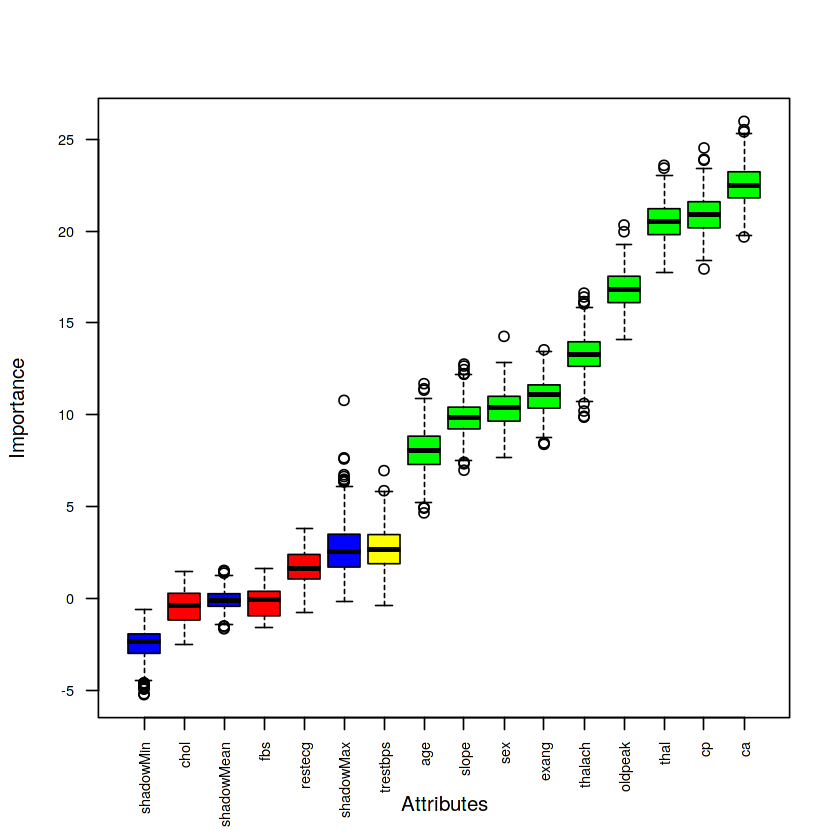

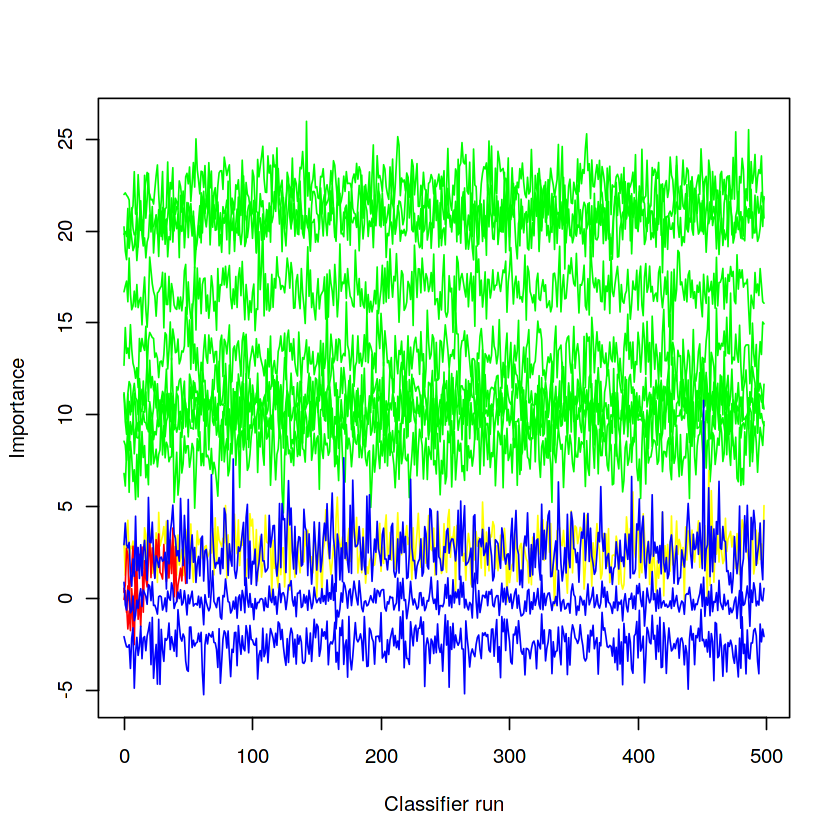

In [6]:
plot(boruta,las=2, cex.axis=0.7)
plotImpHistory(boruta)

In [7]:
#Tentative fix
bor<-TentativeRoughFix(boruta)
print(bor)
attStats(boruta)
getNonRejectedFormula(boruta)
getConfirmedFormula(boruta)

Boruta performed 499 iterations in 2.468362 mins.
Tentatives roughfixed over the last 499 iterations.
 10 attributes confirmed important: age, ca, cp, exang, oldpeak and 5
more;
 3 attributes confirmed unimportant: chol, fbs, restecg;


,meanImp,medianImp,minImp,maxImp,normHits,decision
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
age,8.0468295,8.04719127,4.6571621,11.691575,0.995991984,Confirmed
sex,10.3695082,10.41238902,7.6750545,14.266896,0.997995992,Confirmed
cp,20.9211474,20.90402736,17.9347590,24.522534,1.000000000,Confirmed
trestbps,2.6669370,2.68771745,-0.3845839,6.959539,0.515030060,Tentative
chol,-0.4622686,-0.36879827,-2.5063294,1.443626,0.000000000,Rejected
fbs,-0.1654234,-0.03786923,-1.5764558,1.650382,0.002004008,Rejected
restecg,1.6793203,1.64671166,-0.7437073,3.833266,0.026052104,Rejected
thalach,13.2943871,13.29579191,9.8651951,16.620258,1.000000000,Confirmed
exang,11.0327036,11.07558303,8.3887006,13.534956,1.000000000,Confirmed


target ~ age + sex + cp + trestbps + thalach + exang + oldpeak + 
    slope + ca + thal
<environment: 0x55d23d405098>

target ~ age + sex + cp + thalach + exang + oldpeak + slope + 
    ca + thal
<environment: 0x55d23dc58340>

In [8]:
# New dataframe with the relevant features
heart <-subset(heart, select=getSelectedAttributes(boruta))
heart$target <- heartForLatterUse$target

#### Dummies for categorical data

https://www.kaggle.com/cdabakoglu/heart-disease-classifications-machine-learning/
<br>
In this technique, the categorical variables **cp, slope, thal** are represented by a binary vector. The other categorical variables **sex, fbs, exang** remain the same because their categories are just 0 and 1

In [9]:
options(warnings=-1) #Hide warnings

result1 <- cbind(heart,dummy(heart$cp,sep="cp"))
result2 <- cbind(result1,dummy(heart$slope,sep="slope"))
heartlabel <- cbind(result2,dummy(heart$thal,sep="thal"))


#### To solve multicollinearity, the original categorical variables cp, slope, thal and the first component of the dummies' vectors are revomed
drop <-c("cp","slope","thal","NAcp0","NAslope0","NAthal1")
heartlabel <-heartlabel[,!(names(heartlabel) %in% drop)]
head(heartlabel)
dim(heartlabel)

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”

,age,sex,thalach,exang,oldpeak,ca,target,NAcp1,NAcp2,NAcp3,NAslope1,NAslope2,NAthal2,NAthal3
,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,63,1,150,0,2.3,0,1,0,0,1,0,0,0,0
2,37,1,187,0,3.5,0,1,0,1,0,0,0,1,0
3,41,0,172,0,1.4,0,1,1,0,0,0,1,1,0
4,56,1,178,0,0.8,0,1,1,0,0,0,1,1,0
5,57,0,163,1,0.6,0,1,0,0,0,0,1,1,0
6,57,1,148,0,0.4,0,1,0,0,0,1,0,0,0


[1] 301  14

In [10]:
str(heartlabel)

'data.frame':	301 obs. of  14 variables:
 $ age     : int  63 37 41 56 57 57 56 44 52 57 ...
 $ sex     : int  1 1 0 1 0 1 0 1 1 1 ...
 $ thalach : int  150 187 172 178 163 148 153 173 162 174 ...
 $ exang   : int  0 0 0 0 1 0 0 0 0 0 ...
 $ oldpeak : num  2.3 3.5 1.4 0.8 0.6 0.4 1.3 0 0.5 1.6 ...
 $ ca      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ target  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ NAcp1   : int  0 0 1 1 0 0 1 1 0 0 ...
 $ NAcp2   : int  0 1 0 0 0 0 0 0 1 1 ...
 $ NAcp3   : int  1 0 0 0 0 0 0 0 0 0 ...
 $ NAslope1: int  0 0 0 0 0 1 1 0 0 0 ...
 $ NAslope2: int  0 0 1 1 1 0 0 1 1 1 ...
 $ NAthal2 : int  0 1 1 1 1 0 1 0 0 1 ...
 $ NAthal3 : int  0 0 0 0 0 0 0 1 1 0 ...


#### Splitting Data

In [11]:
set.seed(123)

#Split the data 70% for training and 30% for test
ind <- sample(2,nrow(heartlabel),replace=TRUE,prob=c(0.7,0.3))
heart_train <- heartlabel[ind==1,]
heart_test <- heartlabel[ind==2,]

cat("Dimension of the train dataset: ", dim(heart_train)[1], "x", dim(heart_train)[2])

cat(", Dimension of the test dataset: ", dim(heart_test)[1], "x", dim(heart_test)[2])

Dimension of the train dataset:  216 x 14

, Dimension of the test dataset:  85 x 14

#### Data normalization

Some algorithms in machine learning are more sensitive to the scale of data than others since the distance between the data points is very important.

In order to avoid this problem, a common scale (between 0 and 1) is often used which keeps the distributions of variables the same. This is often referred to as min-max scaling. The formula is shown below
$$z_{i}= \frac{x_{i}-min(x)}{max(x)-min(x)}$$

With $z_{i}$ as the new entry for each $x_{i}$ in the feature analyzed

In [12]:
#Function to normalize
#Parameters: xRef= vector/matrix of reference to normalize, xNorm= vector/matrix to normalize based on xRef
normalize <- function(xRef,xNorm) {
            return ((xNorm - min(xRef)) / (max(xRef) - min(xRef)))
            }

In [13]:
# New dataframes with features normalized
heartTrainNorm <- as.data.frame(mapply(normalize, heart_train,heart_train))

heartTestNorm <- as.data.frame(mapply(normalize, heart_train,heart_test))

#### PCA

##### FIRST ATTEMP WITH PRE-PROCESSED VARIABLES (DUMMY+NORMALIZATION)

In [14]:
# dataframe for train without the target
heartNoTarget <- heartTrainNorm[ , -which(names(heartTrainNorm) %in% c("target"))]

In [15]:
# Find the PCA
heartTrainNormPCA <-prcomp(x = heartNoTarget, scale = FALSE, center = TRUE)

In [16]:
summary(heartTrainNormPCA)

Importance of components:
                          PC1    PC2    PC3    PC4     PC5     PC6     PC7
Standard deviation     0.8465 0.5951 0.4876 0.4301 0.39324 0.32190 0.27601
Proportion of Variance 0.3571 0.1765 0.1185 0.0922 0.07706 0.05163 0.03796
Cumulative Proportion  0.3571 0.5335 0.6520 0.7442 0.82124 0.87287 0.91083
                          PC8     PC9    PC10    PC11    PC12    PC13
Standard deviation     0.2181 0.20879 0.17839 0.16125 0.12553 0.11917
Proportion of Variance 0.0237 0.02172 0.01586 0.01296 0.00785 0.00708
Cumulative Proportion  0.9345 0.95626 0.97212 0.98507 0.99292 1.00000

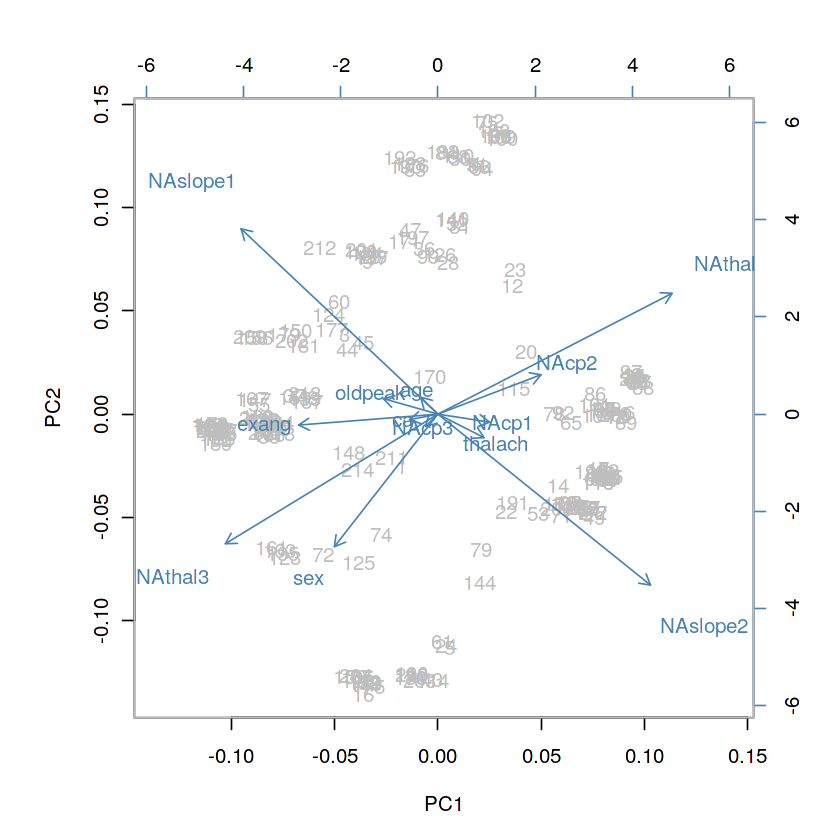

In [17]:
biplot(heartTrainNormPCA, col = c("grey", "steelblue"))

It presents a more even distribution of the loading vectors (because of the scaling)

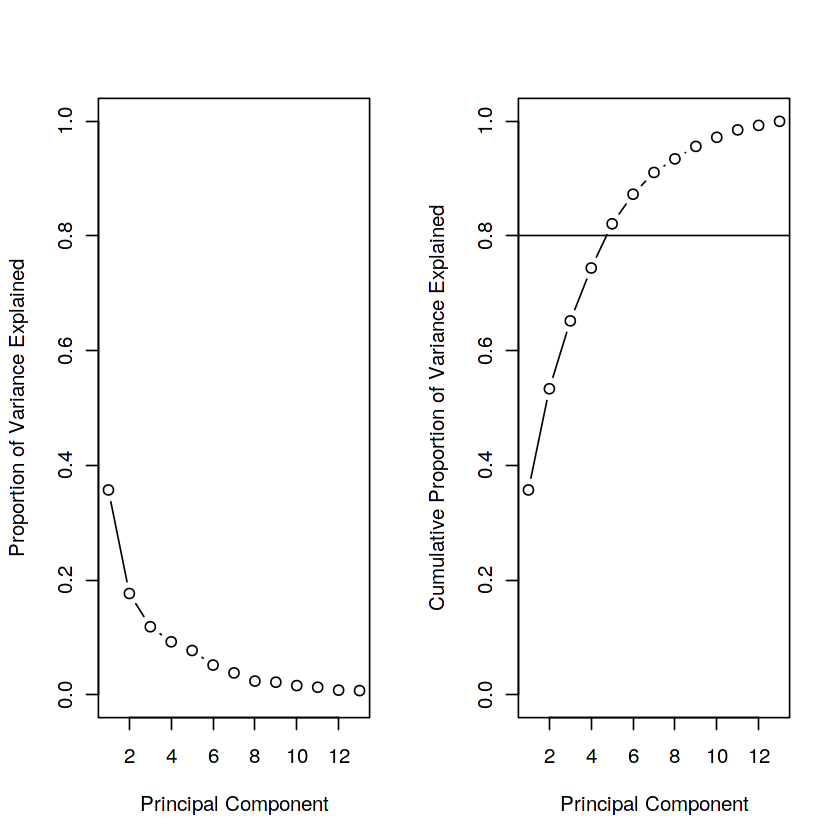

In [18]:
#Getting proportion of variance
heartTrainNormPCAvar <-heartTrainNormPCA$sdev^2
pve <- heartTrainNormPCAvar/sum(heartTrainNormPCAvar) #Proportion of variance of principal components

par(mfrow=c(1,2))
#Plot variance explained for each principal component
plot(pve, xlab = "Principal Component", ylab ="Proportion of Variance Explained", ylim = c(0,1), type ="b")
# Plot cumulative proportion of variance explained
plot(cumsum(pve), xlab = "Principal Component",
     ylab = "Cumulative Proportion of Variance Explained",
     ylim = c(0, 1), type = "b")
abline(h=0.8)

**Conclusion:** Select the first four components

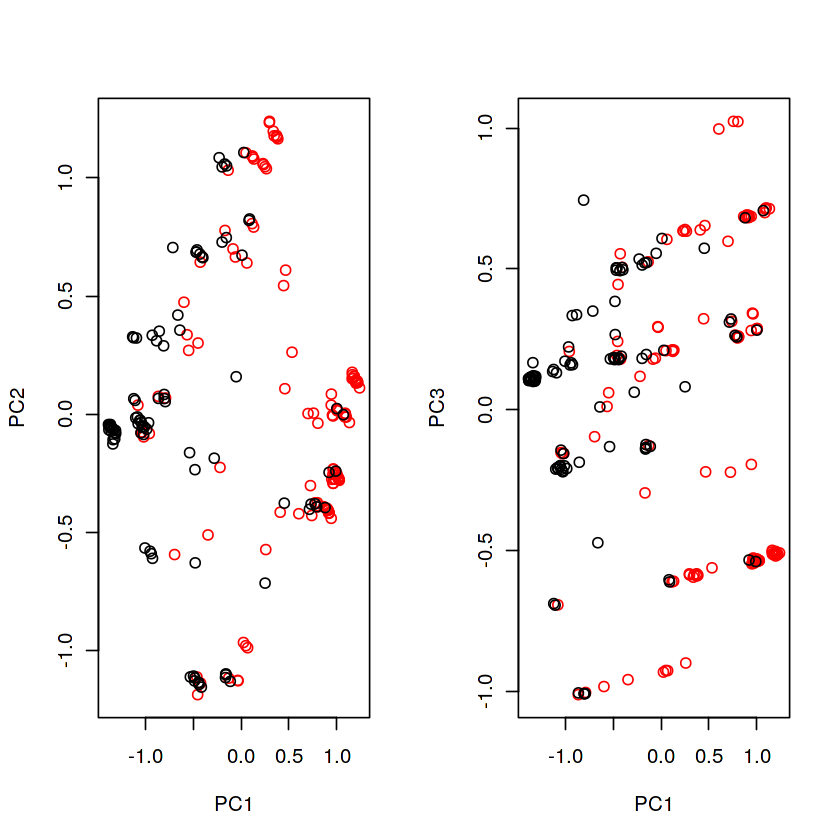

In [19]:
# Scatter plot observations by components 1 and 2
target <- as.numeric(heartTrainNorm$target == 1)
par(mfrow=c(1,2))
plot(heartTrainNormPCA$x[, c(1, 2)], col = (target + 1), 
     xlab = "PC1", ylab = "PC2")

# Repeat for components 1 and 3
plot(heartTrainNormPCA$x[, c(1, 3)], col = (target + 1), 
     xlab = "PC1", ylab = "PC3")

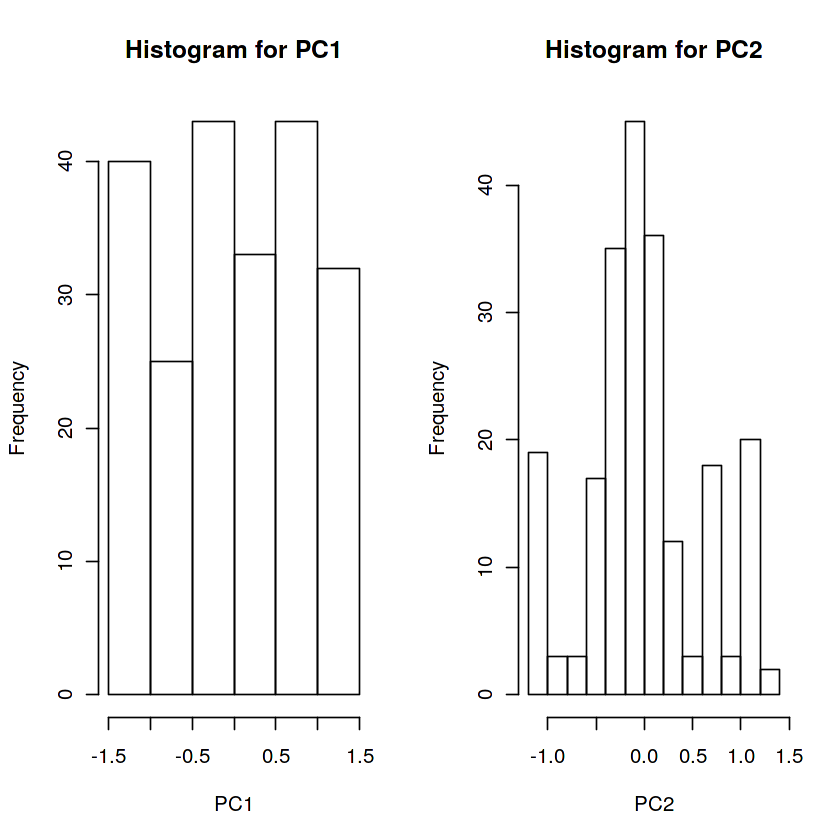

In [20]:
#Histograms of the first two components
par(mfrow=c(1,2))
hist(heartTrainNormPCA$x[, 1], main="Histogram for PC1",xlab="PC1")
hist(heartTrainNormPCA$x[, 2], main="Histogram for PC2",xlab="PC2")

##### SECOND ATTEMP WITH ORIGINAL VARIABLES

In [21]:
#Split data. HELP!! USE THE ENTIRE DATASET OR THE SPLITTED ONE
indOriginal <- sample(2,nrow(heartForLatterUse),replace=TRUE,prob=c(0.7,0.3))
heartOriginal_train <- heartForLatterUse[indOriginal==1,]
heartOriginal_test <- heartForLatterUse[indOriginal==2,]
#PCA with original features
heartOriginalPCA <-prcomp(x = subset(heartOriginal_train,select = -target), scale = FALSE, center = TRUE)
summary(heartOriginalPCA)

Importance of components:
                          PC1     PC2      PC3     PC4     PC5    PC6     PC7
Standard deviation     49.894 22.8240 17.48554 7.55918 1.24695 1.0130 0.86279
Proportion of Variance  0.737  0.1542  0.09052 0.01692 0.00046 0.0003 0.00022
Cumulative Proportion   0.737  0.8912  0.98173 0.99865 0.99911 0.9994 0.99963
                          PC8     PC9    PC10    PC11    PC12    PC13
Standard deviation     0.5848 0.51892 0.45353 0.40966 0.38793 0.32394
Proportion of Variance 0.0001 0.00008 0.00006 0.00005 0.00004 0.00003
Cumulative Proportion  0.9997 0.99981 0.99987 0.99992 0.99997 1.00000

Warning message in arrows(0, 0, y[, 1L] * 0.8, y[, 2L] * 0.8, col = col[2L], length = arrow.len):
“zero-length arrow is of indeterminate angle and so skipped”

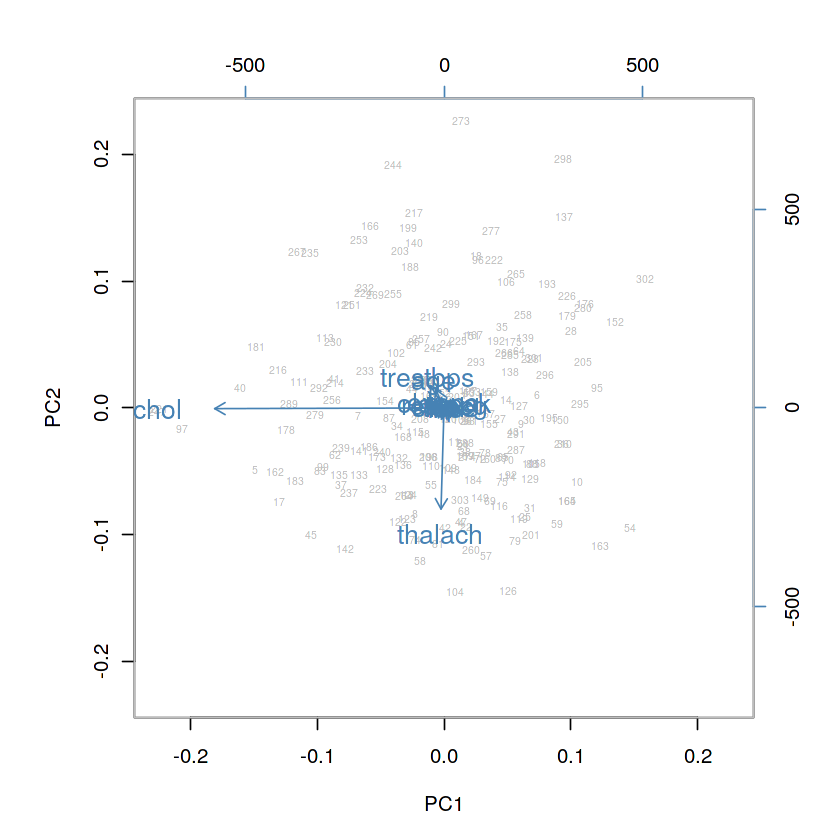

In [22]:
biplot(heartOriginalPCA, col = c("grey", "steelblue"), cex= c(0.5, 1.3))

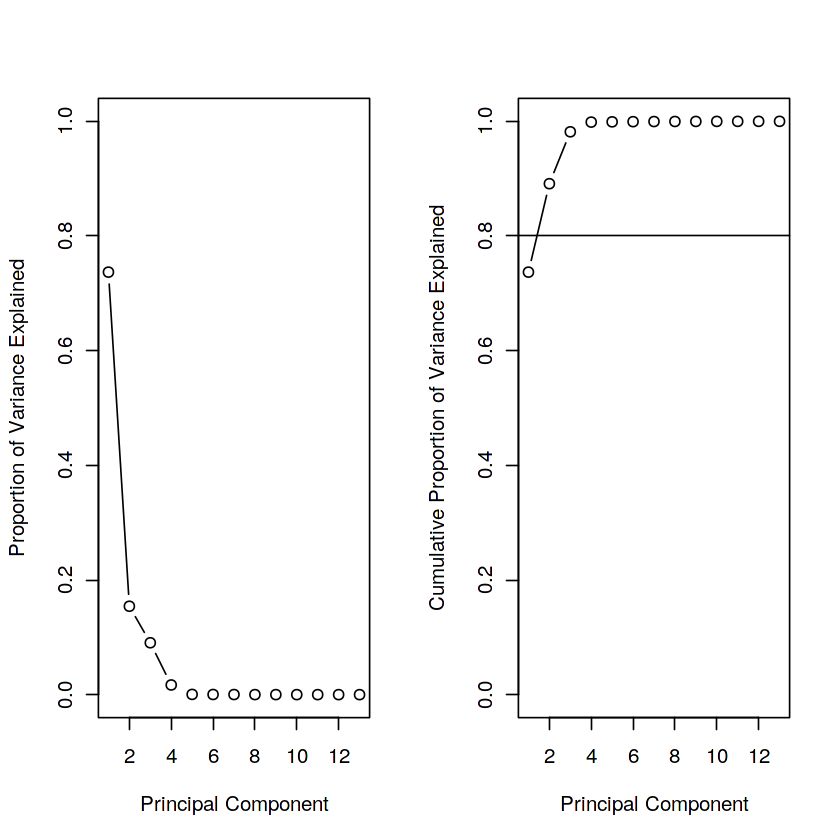

In [23]:
#Getting proportion of variance
heartOriginalPCAvar <-heartOriginalPCA$sdev^2
pve <- heartOriginalPCAvar/sum(heartOriginalPCAvar) #Proportion of variance of principal components

par(mfrow=c(1,2))
#Plot variance explained for each principal component
plot(pve, xlab = "Principal Component", ylab ="Proportion of Variance Explained", ylim = c(0,1), type ="b")
# Plot cumulative proportion of variance explained
plot(cumsum(pve), xlab = "Principal Component",
     ylab = "Cumulative Proportion of Variance Explained",
     ylim = c(0, 1), type = "b")
abline(h=0.8)

**Conclusion:** Select the first component

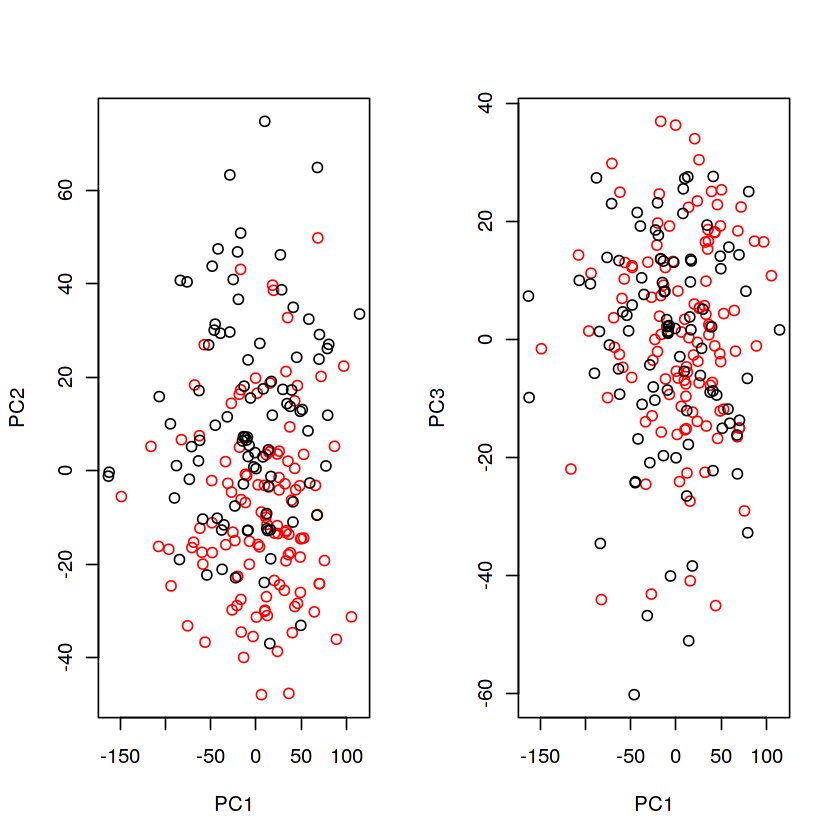

In [24]:
# Scatter plot observations by components 1 and 2
target <- as.numeric(heartOriginal_train$target == 1)
par(mfrow=c(1,2))
plot(heartOriginalPCA$x[, c(1, 2)], col = (target + 1), 
     xlab = "PC1", ylab = "PC2")

# Scatter plot observations by components 1 and 3
plot(heartOriginalPCA$x[, c(1, 3)], col = (target + 1), 
     xlab = "PC1", ylab = "PC3")

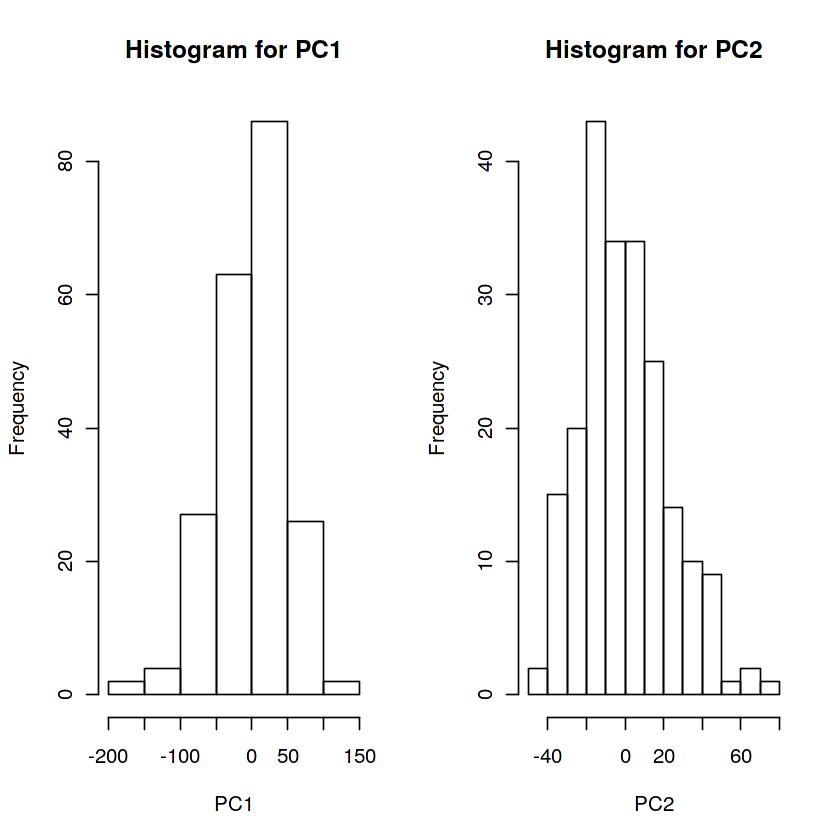

In [25]:
par(mfrow=c(1,2))
hist(heartOriginalPCA$x[, 1], main="Histogram for PC1",xlab="PC1")
hist(heartOriginalPCA$x[, 2], main="Histogram for PC2",xlab="PC2")

#### COMPARISON BETWEEN BOTH PCA ATTEMPS

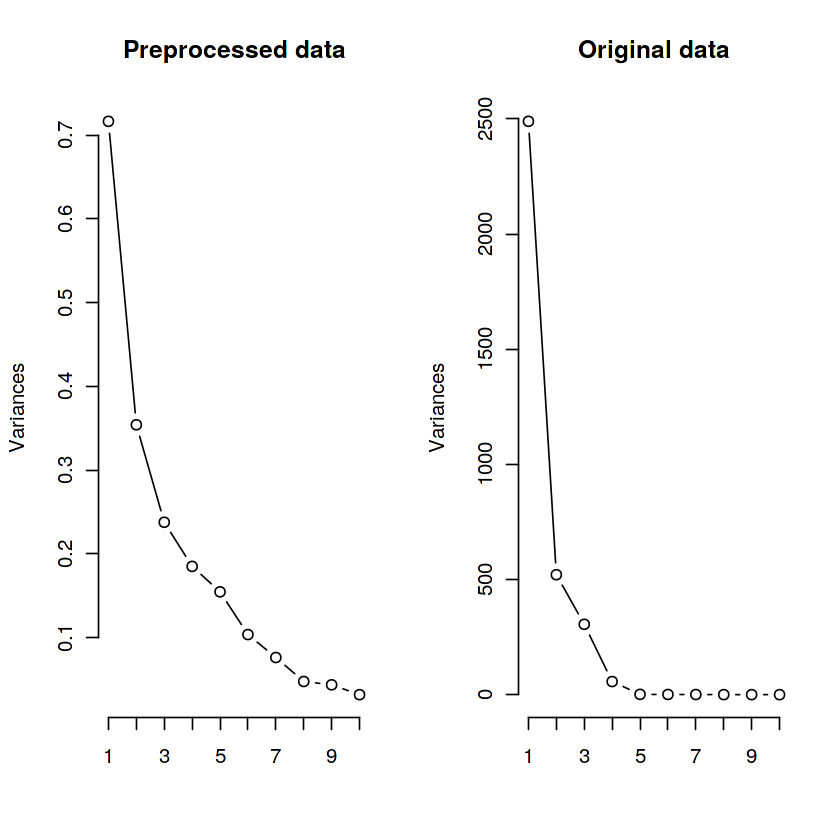

In [26]:
par(mfrow=c(1,2))
screeplot(heartTrainNormPCA, type ="lines", main="Preprocessed data")
screeplot(heartOriginalPCA, type ="lines", main="Original data")

**Conclusion:** It seems as is better to keep the original variables and select the first principal component. **BUT WHY?**

For extracting the values of PCA and use them in the models:
https://www.analyticsvidhya.com/blog/2016/03/pca-practical-guide-principal-component-analysis-python/

#### Linear Discriminant Analysis (LDA)

##### ATTEMP1 USE THE OUTPUT FROM PCA WITH THE FIRST TWO COMPONENTS (ATTEMP1 WITH PREPROCESSED DATA)

In [27]:
# HELP!! TO PERFORM THE LDA IS NECESSARY TO CREATE A NEW DATAFRAME ADDING THE TARGET COLUMN. IS THIS WAY OK?
heartPCAtarget <-as.data.frame(heartTrainNormPCA$x[,c(1,2)])
heartPCAtarget$target <-heartTrainNorm$target

In [28]:
linear <- lda(target~.,data=heartPCAtarget)
linear
p <- predict(linear,heartPCAtarget)
p

Call:
lda(target ~ ., data = heartPCAtarget)

Prior probabilities of groups:
        0         1 
0.4490741 0.5509259 

Group means:
         PC1         PC2
0 -0.6037685 -0.06253912
1  0.4921474  0.05097727

Coefficients of linear discriminants:
          LD1
PC1 1.5385490
PC2 0.3224429

,0,1
1,0.58733891,0.4126611
2,0.03687959,0.9631204
3,0.72175073,0.2782493
4,0.17479776,0.8252022
5,0.50298953,0.4970105
6,0.05676431,0.9432357
7,0.02629466,0.9737053
8,0.07579014,0.9242099
9,0.60303651,0.3969635
10,0.05300290,0.9469971


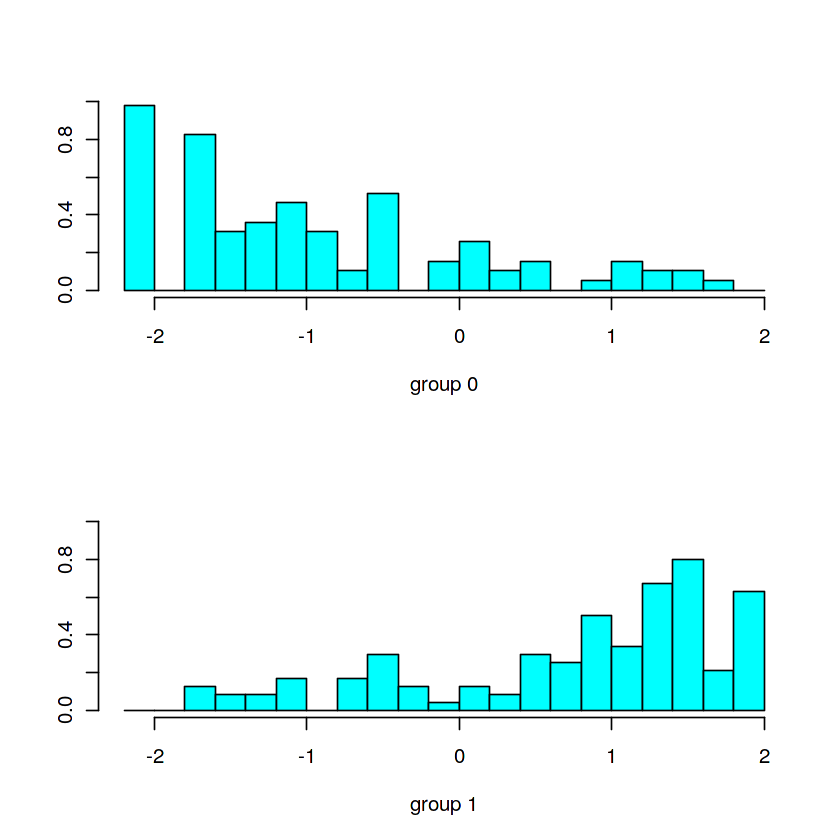

In [29]:
ldahist(data = p$x[, 1], g= heartPCAtarget$target)

In [30]:
#Confusion Matrix testing testing data
p1<- predict(linear, heartPCAtarget)$class
tab <- table(Predicted=p1, Actual=heartPCAtarget$target)
tab
(AccuracyTrainLDA1 <- sum(diag(tab))/sum(tab))


#transform test into PCA
heartPCAtargetTest <- predict(heartTrainNormPCA, newdata = heartTestNorm)
heartPCAtargetTest <- as.data.frame(heartPCAtargetTest)[,c(1,2)]
p2<- predict(linear,heartPCAtargetTest)$class
#Confusion Matrix testing training data
tab2 <- table(Predicted=p2, Actual=heartTestNorm$target)
tab2
(AccuracyTestLDA1 <- sum(diag(tab2))/sum(tab2))

         Actual
Predicted  0  1
        0 75 25
        1 22 94

[1] 0.7824074

         Actual
Predicted  0  1
        0 32  9
        1  8 36

[1] 0.8

29 miss classifications in the model with training data and 15 with testing data, Accuracy of the model: 86.57% with training data and 80% with testing data

Conclusion: LDA do not help us to have a clear separation between the two groups as it can be seen in the past histogram, both variables were not maximally separated. LDA only makes sense in a multiclass setting.

##### ATTEMP2 USE THE OUTPUT FROM PCA WITH THE FIRST TWO COMPONENTS (ATTEMP2 WITH ORIGINAL DATA)

In [31]:
heartOriginalPCAtarget <-as.data.frame(heartOriginalPCA$x[,c(1,2)])
heartOriginalPCAtarget$target <-heartOriginal_train$target

In [32]:
linear <- lda(target~.,heartOriginalPCAtarget)
linear
p <- predict(linear,heartOriginalPCAtarget)
p

Call:
lda(target ~ ., data = heartOriginalPCAtarget)

Prior probabilities of groups:
        0         1 
0.4428571 0.5571429 

Group means:
        PC1      PC2
0 -6.766638 10.98980
1  5.378609 -8.73548

Coefficients of linear discriminants:
             LD1
PC1  0.006060127
PC2 -0.047033407

,0,1
1,0.4517763,0.5482237
4,0.1466425,0.8533575
5,0.4025239,0.5974761
6,0.3911674,0.6088326
7,0.4778077,0.5221923
8,0.1852017,0.8147983
9,0.3218959,0.6781041
10,0.1609077,0.8390923
11,0.3233106,0.6766894
13,0.2266419,0.7733581


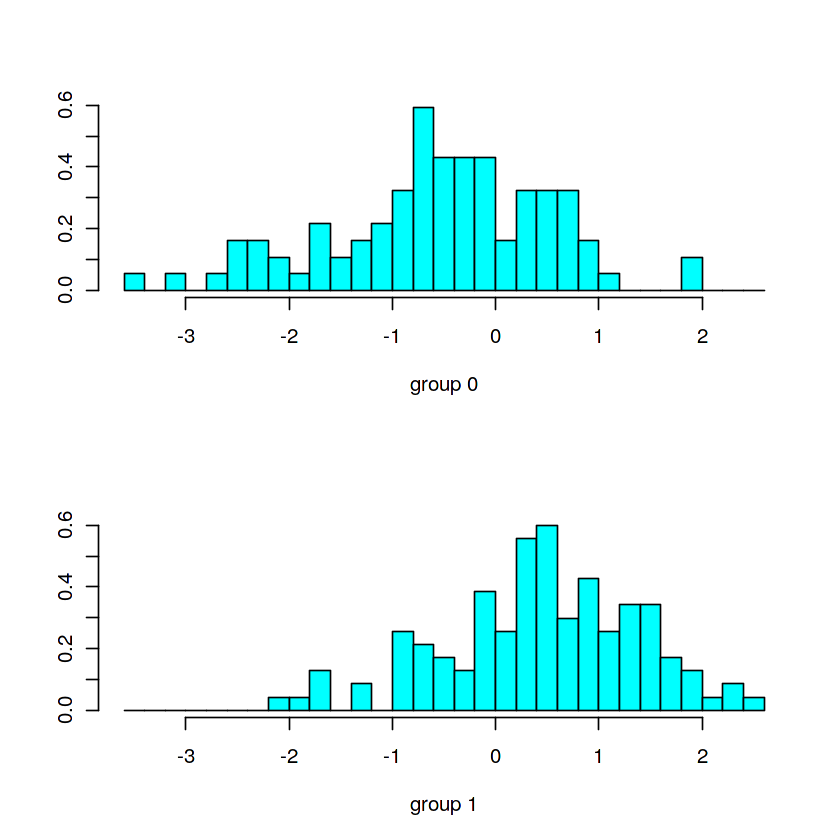

In [33]:
ldahist(data = p$x[, 1], g= heartOriginalPCAtarget$target)

In [34]:
#Confusion Matrix testing data
p1<- predict(linear, heartOriginalPCAtarget)$class
tab <- table(Predicted=p1, Actual=heartOriginalPCAtarget$target)
tab
(AccuracyTrainLDA2 <- sum(diag(tab))/sum(tab))

#transform test into PCA
heartOriginalPCAtargetTest <- predict(heartOriginalPCA, newdata = heartOriginal_test)
heartOriginalPCAtargetTest <- as.data.frame(heartOriginalPCAtargetTest)
p2<- predict(linear,heartOriginalPCAtargetTest)$class
#Confusion Matrix testing training data
tab2 <- table(Predicted=p2, Actual=heartOriginal_test$target)
tab2
(AccuracyTestLDA2 <- sum(diag(tab2))/sum(tab2))

         Actual
Predicted  0  1
        0 57 24
        1 36 93

[1] 0.7142857

         Actual
Predicted  0  1
        0 24  9
        1 20 38

[1] 0.6813187

##### ATTEMP3 USE THE ORIGINAL DATA

In [35]:
linear <- lda(target~.,heartOriginal_train)
linear
p <- predict(linear,heartOriginal_train)
p

Call:
lda(target ~ ., data = heartOriginal_train)

Prior probabilities of groups:
        0         1 
0.4428571 0.5571429 

Group means:
       age       sex        cp trestbps     chol       fbs   restecg  thalach
0 57.44086 0.7849462 0.4193548 135.1398 252.0860 0.1612903 0.4408602 138.8602
1 52.35043 0.5726496 1.3162393 128.1368 240.2735 0.1196581 0.5982906 156.9316
      exang   oldpeak    slope        ca     thal
0 0.5806452 1.7021505 1.172043 1.2150538 2.602151
1 0.1709402 0.5769231 1.581197 0.2905983 2.153846

Coefficients of linear discriminants:
                  LD1
age      -0.014181691
sex      -0.581208002
cp        0.424104985
trestbps -0.007906961
chol     -0.002697311
fbs      -0.109914961
restecg   0.289206876
thalach   0.008453359
exang    -0.640054052
oldpeak  -0.267266320
slope     0.184479977
ca       -0.394976685
thal     -0.548718154

,0,1
1,0.081635974,0.9183640
4,0.045220060,0.9547799
5,0.236919993,0.7630800
6,0.075896714,0.9241033
7,0.132154032,0.8678460
8,0.078859528,0.9211405
9,0.130274679,0.8697253
10,0.036281279,0.9637187
11,0.211999094,0.7880009
13,0.051691686,0.9483083


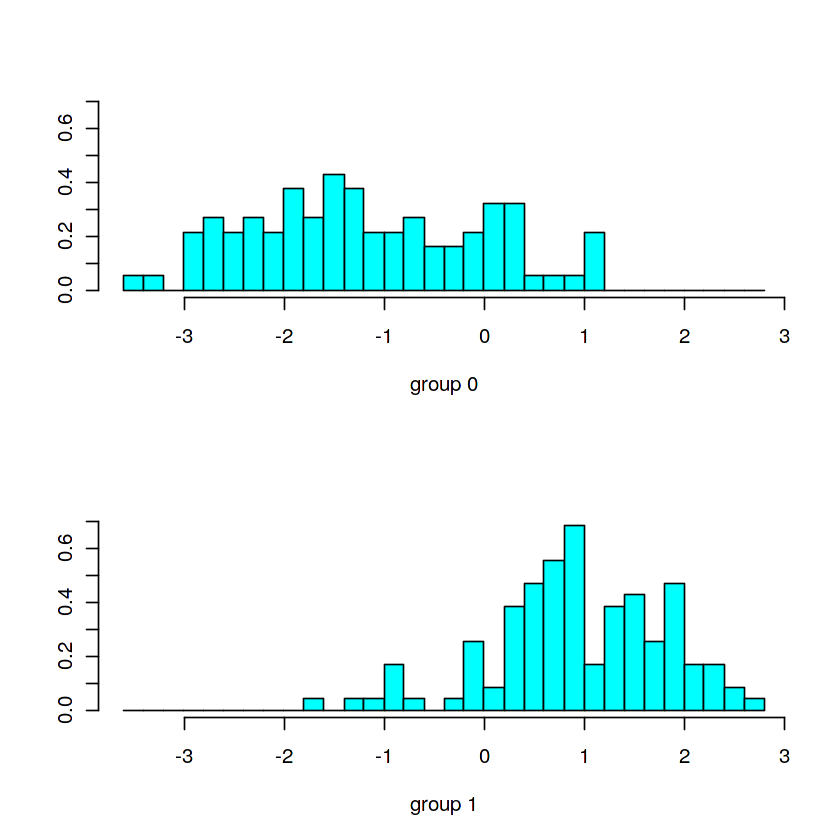

In [36]:
ldahist(data = p$x[, 1], g= heartOriginal_train$target)

In [37]:
#Confusion Matrix testing data
p1<- predict(linear, heartOriginal_train)$class
tab <- table(Predicted=p1, Actual=heartOriginal_train$target)
tab
(AccuracyTrainLDA3 <- sum(diag(tab))/sum(tab))

#Confusion Matrix testing training data
p2<- predict(linear,heartOriginal_test)$class
tab2 <- table(Predicted=p2, Actual=heartOriginal_test$target)
tab2
(AccuracyTestLDA3 <- sum(diag(tab2))/sum(tab2))

         Actual
Predicted   0   1
        0  70   9
        1  23 108

[1] 0.847619

         Actual
Predicted  0  1
        0 30  0
        1 14 47

[1] 0.8461538

##### COMPARISON BETWEEN THE THREE ATTEMPTS FOR LDA

In [38]:
LDA1<-c(AccuracyTrainLDA1,AccuracyTestLDA1)
LDA2<-c(AccuracyTrainLDA2,AccuracyTestLDA2)
LDA3<-c(AccuracyTrainLDA3,AccuracyTestLDA3)

comparison<-data.frame(LDA1,LDA2,LDA3)
row.names(comparison)<-c("Test","Train")
comparison

,LDA1,LDA2,LDA3
,<dbl>,<dbl>,<dbl>
Test,0.7824074,0.7142857,0.8476190
Train,0.8000000,0.6813187,0.8461538


**Conclusion:** HELP!! No idea how to continue with the results of LDA

### Modeling <a class="anchor" id="mo"></a>

The following model is based on the output from PCA (attemp1 with processed data)

#### k-Nearest Neighbors (KNN)

In [39]:
library(class)
# knn(training, test, target_training)
heart_pred <-knn(subset(heartPCAtarget,select = -target),heartPCAtargetTest,heartPCAtarget$target)

In [40]:
# Create a confusion matrix of the predicted versus actual values
heart_actual <- heartTestNorm$target
table(heart_pred, heart_actual)

# Compute the accuracy
mean(heart_pred == heart_actual)

          heart_actual
heart_pred  0  1
         0 26 11
         1 14 34

[1] 0.7058824